In [1]:
import pymongo
from pymongo import ReturnDocument
import pandas as pd
from sklearn import preprocessing
from sklearn.neighbors import KNeighborsClassifier


client = pymongo.MongoClient("localhost", 27017)
db = client.outfitPlanner

In [59]:
outfits = list(db.worns.find({}))

In [341]:
def getWornTimes(outfit):
    if outfit.get("outfitId") == None:
        return 1
    else:
        return db.worns.count_documents({"outfitId": outfit["outfitId"]})
    

In [334]:
dataMapper = lambda outfit: {
    "temp": outfit["weather"]["temp"],
    "worn_times": getWornTimes(outfit),
    "clouds": outfit["weather"]["clouds"],
    "humidity": outfit["weather"]["humidity"],
    "pressure": outfit["weather"]["pressure"],
    "wind_speed": outfit["weather"]["wind_speed"]
}

In [335]:
data = [dataMapper(outfit) for outfit in outfits ]

In [336]:
y_data = pd.DataFrame(outfits)
Y = y_data.loc[:, y_data.columns == "outfitId"]

df = pd.DataFrame(data)
X = df.loc[:, df.columns != 'outfitId']
#scaler = preprocessing.StandardScaler().fit(X)
scaler = preprocessing.MinMaxScaler().fit(X)
X_scaled = scaler.transform(X)

In [338]:
#scale temp and worn_times
X_scaled[:, 0] *= 5
X_scaled[:, 1] *= 2

In [339]:
X_scaled

array([[3.60074627, 0.44444444, 0.        , 0.        , 0.        ,
        0.        ],
       [5.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ],
       [1.26865672, 1.28888889, 0.        , 0.        , 0.        ,
        0.        ],
       [0.        , 0.26666667, 0.        , 0.        , 0.        ,
        0.        ],
       [1.96828358, 1.51111111, 0.        , 0.        , 0.        ,
        0.        ],
       [4.76679104, 1.42222222, 0.        , 0.        , 0.        ,
        0.        ],
       [4.13712687, 2.        , 0.        , 0.        , 0.        ,
        0.        ],
       [3.13432836, 0.13333333, 0.        , 0.        , 0.        ,
        0.        ],
       [3.36753731, 1.02222222, 0.        , 0.        , 0.        ,
        0.        ]])

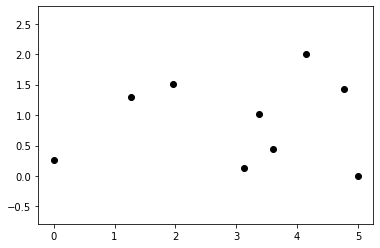

In [340]:
plt.axis('equal')
plt.plot(X_scaled[:, 0], X_scaled[:, 1], 'o', color='black')

In [237]:
neigh = KNeighborsClassifier(n_neighbors=3)
neigh.fit(X_scaled, Y)

c:\users\adam\projekty\outfit-planner\flask-server\op\lib\site-packages\ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


KNeighborsClassifier(n_neighbors=3)

In [238]:
import numpy as np
newCase = np.array([[3, 82, 1004, 50, 4.32]])

newOutfit = dict({
    "weather": dict({
        "clouds": 3,
        "humidity": 82,
        "pressure": 1004,
        "temp": 15,
         "wind_speed": 4.32
    })
})
newOutfitWeighted = dataMapper(newOutfit)
newCase = [newOutfitWeighted]

In [239]:
newCaseDf = pd.DataFrame(newCase)

In [240]:
scaled = scaler.transform(newCaseDf[0:1])
pred_proba = neigh.predict_proba(scaled)
pred_proba = pred_proba[0]

In [241]:
pred_proba

array([0.66666667, 0.33333333, 0.        ])

In [69]:
zipped = zip(neigh.classes_, pred_proba)

In [55]:
sortedOutfits = sorted(zipped, key = lambda t: -t[1])

In [56]:
sortedOutfits

[(36, 0.6666666666666666), (37, 0.3333333333333333), (38, 0.0)]

In [88]:

res = np.array([list(db.outfits.find({"id": int(x[0])})) for x in sortedOutfits]).flatten()

{'_id': ObjectId('5fd3c9e802eed4d62f4e7366'),
 'shoeUri': {'id': 13,
  'localUri': 'file:/data/user/0/host.exp.exponent/files/ExperienceData/%2540nieobranekiwi%252FoutfitPlanner/0ccc81a5-8cbf-4945-8fa7-7c38c38ea39a.jpg'},
 'socksUri': {'id': 36,
  'localUri': 'file:/data/user/0/host.exp.exponent/files/ExperienceData/%2540nieobranekiwi%252FoutfitPlanner/044ea4a7-332b-4c0c-aa86-c67b82292373.jpg'},
 'tshirtUri': {'id': 20,
  'localUri': 'file:/data/user/0/host.exp.exponent/files/ExperienceData/%2540nieobranekiwi%252FoutfitPlanner/ff71ccfb-0219-4d60-8b03-63cbff8e16ab.jpg'},
 'trouserUri': {'id': 24,
  'localUri': 'file:/data/user/0/host.exp.exponent/files/ExperienceData/%2540nieobranekiwi%252FoutfitPlanner/28821799-d589-47e3-8478-6f2cd7c73b58.jpg'},
 'rain': False,
 'id': 37}

In [81]:
int(sortedOutfits[0][0])

36

In [64]:
outfit = db.outfits.find({"id": 36})

In [192]:
%matplotlib inline
import matplotlib.pyplot as plt

In [ ]:
plt.plot(X["temp"], X["clouds"], 'o', color='black');

In [ ]:
fig, ax = plt.subplots()

x = X["temp"]
y = X["pressure"]
pred = neigh.predict(np.array(X_scaled))
ax.scatter(x, y)

for i in range(len(x)):
    ax.annotate(pred[i], (x[i], y[i]))

In [ ]:
fig, ax = plt.subplots()

x = X["temp"]
y = X["pressure"]
pred = neigh.predict(np.array(X_scaled))
ax.scatter(x, y)
yy = Y["outfitId"]
for i in range(len(x)):
    ax.annotate(yy[i], (x[i], y[i]))